In [84]:
#importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import os
from torchvision import models
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import Adam
from torchvision.models import resnet50
import pickle 
import time
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import imutils
from PIL import Image
from base_model import CNN

%matplotlib inline

In [85]:
#setting seed for reproducibility
torch.manual_seed(42)

In [154]:
# Define the base path to the input dataset and specify the subfolders for train, test, and valid
BASE_PATH = "Rock Paper Scissors SXSW.v12i.yolov8"
TRAIN_PATH = os.path.sep.join([BASE_PATH, "train"])
TEST_PATH = os.path.sep.join([BASE_PATH, "test"])
VALID_PATH = os.path.sep.join([BASE_PATH, "valid"])

# Define the paths to the subfolders for images and labels within each split
TRAIN_IMAGES_PATH = os.path.sep.join([TRAIN_PATH, "images"])
TRAIN_LABELS_PATH = os.path.sep.join([TRAIN_PATH, "labels"])
TEST_IMAGES_PATH = os.path.sep.join([TEST_PATH, "images"])
TEST_LABELS_PATH = os.path.sep.join([TEST_PATH, "labels"])
VALID_IMAGES_PATH = os.path.sep.join([VALID_PATH, "images"])
VALID_LABELS_PATH = os.path.sep.join([VALID_PATH, "labels"])

# Define the path to the base output directory
BASE_OUTPUT = "output"

# Define the paths for model, label encoder, plots output, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.pth"])
LE_PATH = os.path.sep.join([BASE_OUTPUT, "le.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

# Now you can use these paths in your code for data loading and saving

In [155]:
#Finding the mean and std of the dataset

#Define the directory where your images are located
image_dir = "Rock Paper Scissors SXSW.v12i.yolov8/valid/images"

# Define a function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    # Resize, convert to NumPy array, and normalize
    image = image.resize((224, 224))  # Adjust size as needed
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image

# Initialize lists to store channel-wise means and std deviations
channel_means = [0.0, 0.0, 0.0]
channel_stds = [0.0, 0.0, 0.0]

# Iterate through the images and calculate means and stds
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):
        image_path = os.path.join(image_dir, filename)
        image = load_and_preprocess_image(image_path)
        for channel in range(3):  # Iterate through RGB channels
            channel_means[channel] += np.mean(image[:, :, channel])
            channel_stds[channel] += np.std(image[:, :, channel])

# Calculate the overall means and stds
num_images = len(os.listdir(image_dir))
overall_means = [mean / num_images for mean in channel_means]
overall_stds = [std / num_images for std in channel_stds]

print("Mean:", overall_means)
print("Standard Deviation:", overall_stds)


Mean: [0.490110532131934, 0.446009729818045, 0.43031791397747016]
Standard Deviation: [0.21694581319104497, 0.20764065161771203, 0.20739287063608627]


In [157]:
# determine the current device and based on that set the pin memory
# flag
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

MEAN = overall_means
STD = overall_stds
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 10
BATCH_SIZE = 16
# specify the loss weights
LABELS = 1.0
BBOX = 1.0

In [158]:
class CustomTensorDataset(Dataset):
	# initialize the constructor
	def __init__(self, tensors, transforms=None):
		self.tensors = tensors
		self.transforms = transforms
	
	def __len__(self):
		# return the size of the dataset
		return self.tensors[0].size(0)

	def __getitem__(self, index):
		# grab the image, label, and its bounding box coordinates
		image = self.tensors[0][index]
		label = self.tensors[1][index]
		bbox = self.tensors[2][index]
		# transpose the image such that its channel dimension becomes
		# the leading one
		image = image.permute(2, 0, 1)
		# check to see if we have any image transformations to apply
		# and if so, apply them
		if self.transforms:
			image = self.transforms(image)
		# return a tuple of the images, labels, and bounding
		# box coordinates
		return (image, label, bbox)
	

In [159]:
#model
class ObjectDetector(nn.Module):
	def __init__(self, baseModel, numClasses):
		super(ObjectDetector, self).__init__()
		# initialize the base model and the number of classes
		self.baseModel = baseModel
		self.numClasses = numClasses
		#self.identity = nn.Identity()
    # build the regressor head for outputting the bounding box
		# coordinates
		self.regressor = nn.Sequential(
			nn.Linear(1024, 128),
			nn.ReLU(),
			nn.Linear(128, 64),
			nn.ReLU(),
			nn.Linear(64, 32),
			nn.ReLU(),
			nn.Linear(32, 4),
			nn.Sigmoid()
		)
		self.classifier = nn.Sequential(
			nn.Linear(1024, 512),
			nn.ReLU(),
			nn.Dropout(),
			nn.Linear(512, 512),
			nn.ReLU(),
			nn.Dropout(),
			nn.Linear(512, self.numClasses),
			nn.Softmax(dim=1)
		)
		self.baseModel.fc_model[-1] = nn.Identity() # helps us extract the features from the base model without the last layer

	def forward(self, x):
      # pass the inputs through the base model and then obtain
      # predictions from two different branches of the network
			features = self.baseModel(x)
			bboxes = self.regressor(features)
			classLogits = self.classifier(features)
			# return the outputs as a tuple
			return (bboxes, classLogits)

In [160]:
# initialize the list of data (images), class labels, target bounding box coordinates, and image paths for training

print("[INFO] loading dataset...")
train_data = []
train_labels = []
train_bboxes = []
train_imagePaths = []

for txtFilename in os.listdir(TRAIN_LABELS_PATH):
    # Combine the paths to the label and image files
    labelFilePath = os.path.join(TRAIN_LABELS_PATH, txtFilename)
    imageFilename, _ = os.path.splitext(txtFilename)
    imageFilePath = os.path.join(TRAIN_IMAGES_PATH, f"{imageFilename}.jpg")

    # Load the contents of the current TXT annotations file
    rows = open(labelFilePath).read().strip().split("\n")

    # Loop over the rows in the TXT file
    if len(rows) == 1:
        # Use the image file path itself to represent empty annotations

        empty_label = 3
        image = cv2.imread(imageFilePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        train_data.append(image)
        train_labels.append(empty_label)
        train_bboxes.append((0.0, 0.0, 0.0, 0.0))  # Use (0, 0, 0, 0) as a placeholder for empty bounding boxes
        train_imagePaths.append(imageFilePath)
    else:
        # Loop over the rows in the TXT file for non-empty annotations
        for row in rows:
            # Split the row into the bounding box coordinates and class label
            row = row.split(" ")
            (label, startX, startY, width, height) = row

            image = cv2.imread(imageFilePath)
            (h, w) = image.shape[:2]
            startX = float(startX) / w
            startY = float(startY) / h
            width = float(width) / w
            height = float(height) / h
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            train_data.append(image)
            train_labels.append(label)
            train_bboxes.append((startX, startY, width, height))
            train_imagePaths.append(imageFilePath)

[INFO] loading dataset...


In [161]:
# initialize the list of data (images), class labels, target bounding box coordinates, and image paths for validation

print("[INFO] loading dataset...")
valid_data = []
valid_labels = []
valid_bboxes = []
valid_imagePaths = []

for txtFilename in os.listdir(VALID_LABELS_PATH):
    # Combine the paths to the label and image files
    labelFilePath = os.path.join(VALID_LABELS_PATH, txtFilename)
    imageFilename, _ = os.path.splitext(txtFilename)
    imageFilePath = os.path.join(VALID_IMAGES_PATH, f"{imageFilename}.jpg")

    # Load the contents of the current TXT annotations file
    rows = open(labelFilePath).read().strip().split("\n")

    # Loop over the rows in the TXT file
    if len(rows) == 1:
       # Use the image file path itself to represent empty annotations
        empty_label = 3  # Define a special label for empty annotations
        image = cv2.imread(imageFilePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        valid_data.append(image)
        valid_labels.append(empty_label)
        valid_bboxes.append((0.0, 0.0, 0.0, 0.0))  # Use (0, 0, 0, 0) as a placeholder for empty bounding boxes
        valid_imagePaths.append(imageFilePath)
    else:
        # Loop over the rows in the TXT file for non-empty annotations
        for row in rows:
            # Split the row into the bounding box coordinates and class label
            row = row.split(" ")
            (label, startX, startY, width, height) = row

            image = cv2.imread(imageFilePath)
            (h, w) = image.shape[:2]
            startX = float(startX) / w
            startY = float(startY) / h
            width = float(width) / w
            height = float(height) / h
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            valid_data.append(image)
            valid_labels.append(label)
            valid_bboxes.append((startX, startY, width, height))
            valid_imagePaths.append(imageFilePath)

[INFO] loading dataset...


In [162]:
# initialize the list of data (images), class labels, target bounding box coordinates, and image paths for testing

print("[INFO] loading dataset...")
test_data = []
test_labels = []
test_bboxes = []
test_imagePaths = []

for txtFilename in os.listdir(TEST_LABELS_PATH):
    # Combine the paths to the label and image files
    labelFilePath = os.path.join(TEST_LABELS_PATH, txtFilename)
    imageFilename, _ = os.path.splitext(txtFilename)
    imageFilePath = os.path.join(TEST_IMAGES_PATH, f"{imageFilename}.jpg")

    # Load the contents of the current TXT annotations file
    rows = open(labelFilePath).read().strip().split("\n")

    # Loop over the rows in the TXT file
    if len(rows) == 1:
       # Use the image file path itself to represent empty annotations
        empty_label = 3  # Define a special label for empty annotations
        image = cv2.imread(imageFilePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        test_data.append(image)
        test_labels.append(empty_label)
        test_bboxes.append((0.0, 0.0, 0.0, 0.0))  # Use (0, 0, 0, 0) as a placeholder for empty bounding boxes
        test_imagePaths.append(imageFilePath)
    else:
        # Loop over the rows in the TXT file for non-empty annotations
        for row in rows:
            # Split the row into the bounding box coordinates and class label
            row = row.split(" ")
            (label, startX, startY, width, height) = row

            image = cv2.imread(imageFilePath)
            (h, w) = image.shape[:2]
            startX = float(startX) / w
            startY = float(startY) / h
            width = float(width) / w
            height = float(height) / h
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            test_data.append(image)
            test_labels.append(label)
            test_bboxes.append((startX, startY, width, height))
            test_imagePaths.append(imageFilePath)

[INFO] loading dataset...


In [163]:
# encoding training labels for classification
le = LabelEncoder()
labels = le.fit_transform(train_labels)

In [164]:
#convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays
train_data = np.array(train_data, dtype="float32")
train_labels = np.array(train_labels)
train_bboxes = np.array(train_bboxes, dtype="float32")
train_imagePaths = np.array(train_imagePaths)

valid_data = np.array(valid_data, dtype="float32")
valid_labels = np.array(valid_labels)
valid_bboxes = np.array(valid_bboxes, dtype="float32")
valid_imagePaths = np.array(valid_imagePaths)

test_data = np.array(test_data, dtype="float32")
test_labels = np.array(test_labels)
test_bboxes = np.array(test_bboxes, dtype="float32")
test_imagePaths = np.array(test_imagePaths)

In [165]:
# converting from string to int as pytorch doesn't accept string labels
test_labels = test_labels.astype(np.int64)
train_labels = train_labels.astype(np.int64)
valid_labels = valid_labels.astype(np.int64)

In [166]:
# Convert NumPy arrays to PyTorch tensors
train_data = torch.tensor(train_data, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.int64)
train_bboxes = torch.tensor(train_bboxes, dtype=torch.float32)

valid_data = torch.tensor(valid_data, dtype=torch.float32)
valid_labels = torch.tensor(valid_labels, dtype=torch.int64)
valid_bboxes = torch.tensor(valid_bboxes, dtype=torch.float32)

test_data = torch.tensor(test_data, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.int64)
test_bboxes = torch.tensor(test_bboxes, dtype=torch.float32)


In [167]:
from torchvision import transforms

# define normalization transforms
transforms = transforms.Compose([
	transforms.ToPILImage(),
	transforms.ToTensor(),
	transforms.Normalize(mean=MEAN, std=STD)
])

In [168]:
# convert NumPy arrays to PyTorch datasets
trainDS = CustomTensorDataset((train_data, train_labels, train_bboxes),
	transforms=transforms)
validDS = CustomTensorDataset((valid_data, valid_labels, valid_bboxes), transforms=transforms)
testDS = CustomTensorDataset((test_data, test_labels, test_bboxes),
	transforms=transforms)
print("[INFO] total training samples: {}...".format(len(trainDS)))
print("[INFO] total test samples: {}...".format(len(testDS)))

[INFO] total training samples: 12090...
[INFO] total test samples: 351...


In [169]:
#creating dataloaders
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(testDS) // BATCH_SIZE

if __name__ == '__main__':
	# create data loaders
	trainLoader = DataLoader(trainDS, batch_size=BATCH_SIZE,
		shuffle=True, num_workers=0, pin_memory=PIN_MEMORY, drop_last=True)
	validLoader = DataLoader(validDS, batch_size=BATCH_SIZE, num_workers=0, pin_memory=PIN_MEMORY)
	testLoader = DataLoader(testDS, batch_size=BATCH_SIZE,
		num_workers=0, pin_memory=PIN_MEMORY)

In [170]:
# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(test_imagePaths))
f.close()

baseModel = CNN()

for param in baseModel.parameters():
    param.requires_grad = False


[INFO] saving testing image paths...


In [171]:
# create our custom object detector model and flash it to the current
# device

objectDetector = ObjectDetector(baseModel, 4)
objectDetector = objectDetector.to(DEVICE)
objectDetector.load_state_dict(torch.load('model_weights.pth'))

# define our loss functions
classLossFunc = CrossEntropyLoss()
bboxLossFunc = MSELoss()
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(objectDetector.parameters(), lr=INIT_LR)
print(objectDetector)
# initialize a dictionary to store training history
H = {"total_train_loss": [], "total_val_loss": [], "train_class_acc": [],
	 "val_class_acc": []}

ObjectDetector(
  (baseModel): CNN(
    (cnn_model): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
      (7): ReLU()
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (11): ReLU()
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (13): ReLU()
      (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (fc_model): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=25600, out_fea

In [172]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	objectDetector.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0

	# loop over the training set
	for (images, labels, bboxes) in trainLoader:
		# send the input to the device
		(images, labels, bboxes) = (images.to(DEVICE),
			labels.to(DEVICE), bboxes.to(DEVICE))
		# perform a forward pass and calculate the training loss
		predictions = objectDetector(images)
		bboxLoss = bboxLossFunc(predictions[0], bboxes)
		classLoss = classLossFunc(predictions[1], labels)
		totalLoss = (BBOX * bboxLoss) + (LABELS * classLoss)
		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		totalLoss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += totalLoss
		trainCorrect += (predictions[1].argmax(1) == labels).type(
			torch.float).sum().item()
		
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		objectDetector.eval()
		# loop over the validation set
		for (images, labels, bboxes) in testLoader:
			# send the input to the device
			(images, labels, bboxes) = (images.to(DEVICE),
				labels.to(DEVICE), bboxes.to(DEVICE))
			# make the predictions and calculate the validation loss
			predictions = objectDetector(images)
			bboxLoss = bboxLossFunc(predictions[0], bboxes)
			classLoss = classLossFunc(predictions[1], labels)
			totalLoss = (BBOX * bboxLoss) + \
				(LABELS * classLoss)
			totalValLoss += totalLoss
			# calculate the number of correct predictions
			valCorrect += (predictions[1].argmax(1) == labels).type(
				torch.float).sum().item()

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDS)
	valCorrect = valCorrect / len(testDS)
	# update our training history
	H["total_train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_class_acc"].append(trainCorrect)
	H["total_val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_class_acc"].append(valCorrect)
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(
		avgValLoss, valCorrect))
			
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


 10%|█         | 1/10 [02:22<21:24, 142.77s/it]

[INFO] EPOCH: 1/10
Train loss: 1.093805, Train accuracy: 0.8131
Val loss: 0.911418, Val accuracy: 0.8746


 20%|██        | 2/10 [04:18<16:56, 127.07s/it]

[INFO] EPOCH: 2/10
Train loss: 0.930402, Train accuracy: 0.8129
Val loss: 0.910529, Val accuracy: 0.8746


 30%|███       | 3/10 [06:22<14:37, 125.33s/it]

[INFO] EPOCH: 3/10
Train loss: 0.930313, Train accuracy: 0.8127
Val loss: 0.910460, Val accuracy: 0.8746


 40%|████      | 4/10 [08:24<12:25, 124.21s/it]

[INFO] EPOCH: 4/10
Train loss: 0.930021, Train accuracy: 0.8130
Val loss: 0.910443, Val accuracy: 0.8746


 50%|█████     | 5/10 [10:31<10:25, 125.01s/it]

[INFO] EPOCH: 5/10
Train loss: 0.930263, Train accuracy: 0.8127
Val loss: 0.910437, Val accuracy: 0.8746


 60%|██████    | 6/10 [12:34<08:17, 124.33s/it]

[INFO] EPOCH: 6/10
Train loss: 0.930094, Train accuracy: 0.8129
Val loss: 0.910434, Val accuracy: 0.8746


 70%|███████   | 7/10 [15:07<06:41, 133.79s/it]

[INFO] EPOCH: 7/10
Train loss: 0.930176, Train accuracy: 0.8128
Val loss: 0.910432, Val accuracy: 0.8746


 80%|████████  | 8/10 [17:49<04:45, 142.77s/it]

[INFO] EPOCH: 8/10
Train loss: 0.930176, Train accuracy: 0.8128
Val loss: 0.910432, Val accuracy: 0.8746


 90%|█████████ | 9/10 [20:03<02:20, 140.19s/it]

[INFO] EPOCH: 9/10
Train loss: 0.930010, Train accuracy: 0.8130
Val loss: 0.910431, Val accuracy: 0.8746


100%|██████████| 10/10 [22:04<00:00, 132.47s/it]

[INFO] EPOCH: 10/10
Train loss: 0.930176, Train accuracy: 0.8128
Val loss: 0.910431, Val accuracy: 0.8746
[INFO] total time taken to train the model: 1324.75s


In [173]:
# serialize the model to disk
print("[INFO] saving object detector model...")
torch.save(objectDetector, MODEL_PATH)

[INFO] saving object detector model...


In [174]:

# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(LE_PATH, "wb")
f.write(pickle.dumps(le))
f.close()

[INFO] saving label encoder...


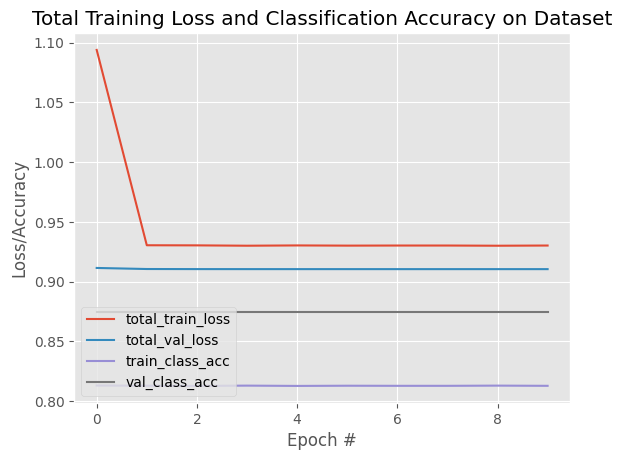

In [175]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["total_train_loss"], label="total_train_loss")
plt.plot(H["total_val_loss"], label="total_val_loss")
plt.plot(H["train_class_acc"], label="train_class_acc")
plt.plot(H["val_class_acc"], label="val_class_acc")
plt.title("Total Training Loss and Classification Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# save the training plot
plotPath = os.path.sep.join([PLOTS_PATH, "training.png"])
plt.savefig(plotPath)